# Import

In [1]:
# import libraries
import os
import csv
import pickle as pk
import itertools
import time
from collections import defaultdict

import pulp
import numpy as np
import random
import math
from scipy.stats import poisson

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Parameters

In [2]:
# network parameters
net_para = {}

# nodes
net_para['o_nodes'] = [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 14, 15]
net_para['u_nodes'] = [8, 9, 13]

# links
net_para['o_links'] = [(1, 2), (1, 6),
                       (2, 3),
                       (3, 8), (3, 7), (3, 4),
                       (4, 5),
                       (5, -1),
                       (6, 7), (6, 11),
                       (7, 8), (7, 12),
                       (10, 5), (10, 15),
                       (11, -1),
                       (12, 7), (12, 11),
                       (14, 15),
                       (15, -1)]
net_para['u_links'] = [(8, 9),
                       (9, 10), (9, 15),
                       (13, 9), (13, 12),(13, 14)]

# neighbors
net_para['neighbors'] = defaultdict(list)
for start, end in net_para['o_links']+net_para['u_links']:
    net_para['neighbors'][start].append(end)

# arrival rates
net_para['arr_rates'] = {1: [10, 0.6],
                         3: [10, 0.6], 
                         13: [10, 0.6]}

# capacities
net_para['capacities'] = defaultdict(lambda:5)

In [3]:
sim_para = {}
sim_para['sample_num'] = 5
sim_para['time_horizon'] = 5000

sim_para['observation_slots'] = []
sim_para['method'] = 'Null'

# file operations
sim_para['path'] = ("T" + str(sim_para['time_horizon']) + 
                    "_SN" + str(sim_para['sample_num']) + '/')
os.makedirs(sim_para['path'], exist_ok=True)

# Network

In [4]:
class Network:

    # initialization
    def __init__(self, net_para):
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.o_nodes = net_para['o_nodes']
        self.u_nodes = net_para['u_nodes']
        self.ao_nodes = [node for node in self.a_nodes if node in self.o_nodes]
        self.au_nodes = [node for node in self.a_nodes if node in self.u_nodes]
        self.o_links = net_para['o_links']
        self.u_links = net_para['u_links']
        self.neighbors = net_para['neighbors']
        # states
        self.A = {node:0 for node in self.a_nodes}
        self.Q = {node:0 for node in self.o_nodes+self.u_nodes}
        self.X = {node:0 for node in self.u_nodes}
        self.Y = {node:0 for node in self.u_nodes}
        # actions
        self.m = {node:0 for node in self.a_nodes}
        self.f = {link:0 for link in self.o_links+self.u_links}
        self.g = {link:0 for link in self.u_links}
        # records of states
        self.A_log = {node:[] for node in self.a_nodes}
        self.Q_log = {node:[] for node in self.o_nodes+self.u_nodes}
        self.X_log = {node:[] for node in self.u_nodes}
        self.Y_log = {node:[] for node in self.u_nodes}
        # records of actions
        self.m_log = {node:[] for node in self.a_nodes}
        self.f_log = {link:[] for link in self.o_links+self.u_links}
        self.g_log = {link:[] for link in self.u_links}

    # receive external arrivals
    def Arrive(self, arr): 
        for node in self.a_nodes:
            self.A[node] = arr[node]
        return
        
    # admit packets into the network
    def Admit(self, adm, adm_u):
        # update overlay nodes
        for node in self.ao_nodes:
            self.m[node] = adm[node]
            self.Q[node] += adm[node]
        # update underlay nodes
        for node in self.au_nodes:
            self.m[node] = adm_u[node]
            self.Q[node] += adm_u[node]
            self.X[node] += adm_u[node]
        return

        # service
    def Serve(self, ser, ser_u):
        for start, end in self.o_links+self.u_links:
            # overlay -> overlay
            if start in self.o_nodes and end in self.o_nodes:
                self.f[(start, end)] = min(ser[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)]
                self.Q[end] += self.f[(start, end)]
            # overlay -> underlay
            elif start in self.o_nodes and end in self.u_nodes:
                self.f[(start, end)] = min(ser[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)]
                # overlay -> real underlay
                self.Q[end] += self.f[(start, end)]
                # overlay -> imaginary underlay
                self.X[end] += self.f[(start, end)]
            # overlay -> sink
            elif start in self.o_nodes and end == -1:
                self.f[(start, end)] = min(ser[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)] 
            # underlay -> overlay
            elif start in self.u_nodes and end in self.o_nodes:
                # real underlay -> overlay
                self.f[(start, end)] = min(ser_u[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)]
                self.Q[end] += self.f[(start, end)]
                # imaginary underlay -> overlay
                self.g[(start, end)] = min(ser[(start, end)], self.X[start])
                self.X[start] -= self.g[(start, end)]
            # underlay -> underlay
            elif start in self.u_nodes and end in self.u_nodes:
                # real underlay -> real underlay
                self.f[(start, end)] = min(ser_u[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)]
                self.Q[end] += self.f[(start, end)]
                # imaginary underlay -> imaginary underlay
                self.g[(start, end)] = min(ser[(start, end)], self.X[start])
                self.X[start] -= self.g[(start, end)]
                self.X[end] += self.g[(start, end)]
            # underlay -> sink
            elif start in self.u_nodes and end == -1:
                # real underlay -> sink
                self.f[(start, end)] = min(ser_u[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)] 
                # imaginary underlay -> sink
                self.g[(start, end)] = min(ser[(start, end)], self.X[start])
                self.X[start] -= self.g[(start, end)] 
        return
    
    # update the gap
    def UpdateY(self):
        for node in self.u_nodes:
            self.Y[node] = max(self.Q[node] - self.X[node], 0)
        return

    # record 
    def Record(self):
        # record A
        for node in self.a_nodes:
            self.A_log[node].append(self.A[node])
        # record Q
        for node in self.o_nodes+self.u_nodes:
            self.Q_log[node].append(self.Q[node])
        # record X and Y
        for node in self.u_nodes:
            self.X_log[node].append(self.X[node])
            self.Y_log[node].append(self.Y[node])
        # record m
        for node in self.a_nodes:
            self.m_log[node].append(self.m[node])
        # record f
        for link in self.o_links+self.u_links:
            self.f_log[link].append(self.f[link])
        # record g
        for link in self.u_links:
            self.g_log[link].append(self.g[link])
        return

# Simulation

In [5]:
class Simulation:
    
    # initialization
    def __init__(self, net_para, sim_para):
        self.net_para = net_para
        self.sim_para = sim_para
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.o_nodes = net_para['o_nodes']
        self.u_nodes = net_para['u_nodes']
        self.o_links = net_para['o_links']
        self.u_links = net_para['u_links']
        # simulation parameters
        self.sample_num = sim_para['sample_num']
        self.time_horizon = sim_para['time_horizon']
        self.method = sim_para['method']
        self.observation_slots = sim_para['observation_slots']
        # records of queues
        self.A_log_samples = []
        self.Q_log_samples = []
        self.X_log_samples = []
        self.Y_log_samples = []
        # records of actions
        self.m_log_samples = []
        self.f_log_samples = []
        self.g_log_samples = []
    
    # main process of simulation
    def Simulate(self):
        for sample_idx in range(self.sample_num): 
            start_time = time.time()
            net = Network(self.net_para)
            solver = self.Solver()
            gen = Generator(self.net_para, self.sim_para)
            for t in range(self.time_horizon):
                # arrival
                arr = gen.GenArr(t)
                net.Arrive(arr)
                # update Y
                if t in self.observation_slots:
                    net.UpdateY()
                # calculate actions
                adm, ser = solver.Service(net.A, net.Q, net.X, net.Y)   
                # packet admission
                adm_u = gen.GenAdmU(t)
                net.Admit(adm, adm_u)
                # service
                ser_u = gen.GenSerU(t)
                net.Serve(ser, ser_u)
                # record
                net.Record()                
                # display process
                if t % 100 == 99:
                    print('\r' + self.method + ', sample index = ' + str(sample_idx) + ', t = ' + str(t) + ', ' + str(time.time()-start_time), end='')
                    if t == self.time_horizon - 1:
                        print('\r')
            # record results
            self.A_log_samples.append(net.A_log)
            self.Q_log_samples.append(net.Q_log)
            self.X_log_samples.append(net.X_log)
            self.Y_log_samples.append(net.Y_log)
            self.m_log_samples.append(net.m_log)
            self.f_log_samples.append(net.f_log)
            self.g_log_samples.append(net.g_log)
        return
    
    # initialize the solver
    def Solver(self):
        if self.method[:3] == 'TDP':
            return TDP(self.net_para, self.sim_para)
        elif self.method == 'Rand':
            return Randomized()
        elif self.method[:2] == 'DP':
            return DP(self.net_para, self.sim_para)
        else:
            return Null()
    
    # calculate the total queue backlogs
    def CalTotalQueue(self):
        total_queue = [0] * self.time_horizon
        for t in range(self.time_horizon):
            for sample_idx in range(self.sample_num):
                total_queue[t] += sum(self.Q_log_samples[sample_idx][node][t] for node in self.o_nodes+self.u_nodes)/self.sample_num
        return total_queue
    
    # calculate the average utility
    def CalAveUtility(self):
        ave_utility = [0] * self.time_horizon
        for t in range(self.time_horizon):
            utility = 0
            for sample_idx in range(self.sample_num): 
                utility += sum(self.m_log_samples[sample_idx][node][t] for node in self.a_nodes)/self.sample_num
                ave_utility[t] = (ave_utility[t-1]*t + utility)/(t+1)
        return ave_utility

# Generator

In [6]:
class Generator:
    
    # initialization
    def __init__(self, net_para, sim_para):
        self.arr_rates = net_para['arr_rates']
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.u_nodes = net_para['u_nodes']
        self.au_nodes = [node for node in self.a_nodes if node in self.u_nodes]
        self.u_links = net_para['u_links']
        self.time_horizon = sim_para['time_horizon']
        # generate stochastic arrival sequences
        self.arr_seq = {}
        for node in self.a_nodes:
            num, prob = self.arr_rates[node]
#             self.arr_seq[node] = np.random.choice([0, num], self.time_horizon, p = [1-prob, prob])
            self.arr_seq[node] = np.random.randint(0, 2*num*prob+1, self.time_horizon)
        # generate stochastic underlay service sequences
        self.ser_u_seq = {}
        for link in self.u_links:
            self.ser_u_seq[link] = np.random.randint(0, 6, self.time_horizon)
    
    # generate external arrivals
    def GenArr(self, t):
        arr = {}
        for node in self.a_nodes:
            arr[node] = self.arr_seq[node][t]
        return arr
    
    # generate underlay admissions (admit all packets)
    def GenAdmU(self, t):
        adm_u = {}
        for node in self.au_nodes:
            adm_u[node] = self.arr_seq[node][t]
        return adm_u
    
    # generate underlay services
    def GenSerU(self, t):
        ser_u = {}
        for link in self.u_links:
            ser_u[link] = self.ser_u_seq[link][t]
        return ser_u

# Solvers

## TDP

In [7]:
class TDP:
    
    # initialization
    def __init__(self, net_para, sim_para):
        # network parameters
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.o_nodes = net_para['o_nodes']
        self.u_nodes = net_para['u_nodes']
        self.ao_nodes = [node for node in self.a_nodes if node in self.o_nodes]
        self.au_nodes = [node for node in self.a_nodes if node in self.u_nodes]
        self.o_links = net_para['o_links']
        self.u_links = net_para['u_links']
        self.capacities = net_para['capacities']
        # simulation parameters
        method_para = sim_para['method'].split('_')
        self.coeV = float(method_para[1]) # the coefficient of V
        self.alpha = float(method_para[2]) # if equal to -1, means need to learn
        self.is_V_known = (method_para[3] == 'T')
        self.t = 0
        self.est_T = 1
        # initialize variable m's
        self.m = {}
        for node in self.ao_nodes:
            self.m[node] = pulp.LpVariable('m'+'_'+str(node), lowBound=0, 
                                           upBound=0, cat='Integer')
        # initialize variable f's
        self.f = {}
        for link in self.o_links:
            self.f[link] = pulp.LpVariable('f'+'_'+str(link[0])+'_'+str(link[1]), lowBound=0, 
                                           upBound=self.capacities[link], cat='Integer')
        # initialize variable g's
        self.g = {}
        for link in self.u_links:
            self.g[link] = pulp.LpVariable('g'+'_'+str(link[0])+'_'+str(link[1]), lowBound=0, 
                                           upBound=self.capacities[link], cat='Integer')
        # initialize the solver
        self.solver = pulp.PULP_CBC_CMD(msg=False)

    # compute the action
    def Service(self, A, Q, X, Y):
        # determine V
        if self.is_V_known:
            V = self.coeV
        else:
            if self.t >= self.est_T: self.est_T *= 2
            V = self.coeV * self.est_T**((1+self.alpha)/2)
        # formulate the problem
        problem = self.Formulate(A, Q, X, Y, V)
        # solve the problem
        problem.solve(self.solver)
        # get the result for admission
        adm = {}
        for node in self.ao_nodes:
            val = pulp.value(self.m[node])
            adm[node] = int(val) if val != None else 0
        # get the result for service
        ser = {}
        for link in self.o_links:
            val = pulp.value(self.f[link])
            ser[link] = int(val) if val != None else 0
        for link in self.u_links:
            val = pulp.value(self.g[link])
            ser[link] = int(val) if val != None else 0
        ser[(5, -1)] = self.capacities[(5, -1)]
        ser[(11, -1)] = self.capacities[(11, -1)]
        ser[(15, -1)] = self.capacities[(15, -1)]
        self.t += 1
        return adm, ser
        
    # initialize the problem
    def Formulate(self, A, Q, X, Y, V):
        # update variable m's
        for node in self.ao_nodes:
            self.m[node] = pulp.LpVariable('m'+'_'+str(node), lowBound=0, 
                                           upBound=A[node], cat='Integer')
        # formulate the problem
        problem = pulp.LpProblem("TDP", pulp.LpMinimize)
        problem += (
            Q[1] * (self.m[1] - self.f[(1, 2)] - self.f[(1, 6)]) + 
            Q[2] * (self.f[(1, 2)] - self.f[(2, 3)]) + 
            Q[3] * (self.m[3] + self.f[(2, 3)] - self.f[(3, 4)] - self.f[(3, 7)] - self.f[(3, 8)]) + 
            Q[4] * (self.f[(3, 4)] - self.f[(4, 5)]) + 
            Q[5] * (self.f[(4, 5)] + self.f[(10, 5)]) + 
            Q[6] * (self.f[(1, 6)] - self.f[(6, 7)] - self.f[(6, 11)]) + 
            Q[7] * (self.f[(3, 7)] + self.f[(6, 7)] + self.f[(12, 7)] - self.f[(7, 8)] - self.f[(7, 12)]) + 
            Q[10] * (self.g[(9, 10)] - self.f[(10, 5)] - self.f[(10, 15)]) + 
            Q[11] * (self.f[(6, 11)] + self.f[(12, 11)]) + 
            Q[12] * (self.f[(7, 12)] + self.g[(13, 12)] - self.f[(12, 7)] - self.f[(12, 11)]) + 
            Q[14] * (self.g[(13, 14)] - self.f[(14, 15)]) + 
            Q[15] * (self.g[(9, 15)] + self.f[(10, 15)] + self.f[(14, 15)]) + 
            X[8] * (self.f[(3, 8)] + self.f[(7, 8)] - self.g[(8, 9)]) +  
            X[9] * (self.g[(8, 9)] + self.g[(13, 9)] - self.g[(9, 10)] - self.g[(9, 15)]) + 
            X[13] * (- self.g[(13, 9)] - self.g[(13, 12)] - self.g[(13, 14)]) - 
            Y[8] * (-self.g[(8, 9)]) - 
            Y[9] * (self.g[(8, 9)] + self.g[(13, 9)] - self.g[(9, 10)] - self.g[(9, 15)]) - 
            Y[13] * (- self.g[(13, 9)] - self.g[(13, 12)] - self.g[(13, 14)])
            - V * self.m[1]
            - V * self.m[3]
        ), "Z"
        return problem

## Randomized

In [8]:
class Randomized:
    
    # initialization
    def __init__(self):
        return
    
    # compute the action
    def Service(self, *_):
        # 1 -> 6 -> 11 -> d
        ser = defaultdict(int)
        ser[(1, 6)] = 5
        ser[(6, 11)] = 5
        ser[(11, -1)] = 5
        # 3 -> 4 -> 5 -> d
        ser[(3, 4)] = 5
        ser[(4, 5)] = 5
        ser[(5, -1)] = 5
        # 12 -> 7
        # 14 -> 15 -> d
        # 10 -> 15 -> d
        ser[(12, 7)] = 5
        ser[(7, 8)] = 5
        ser[(14, 15)] = 5
        ser[(10, 15)] = 5
        ser[(15, -1)] = 5

        return ser

## DP

In [9]:
class DP:
    
 # initialization
    def __init__(self, net_para, sim_para):
        # network parameters
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.o_nodes = net_para['o_nodes']
        self.u_nodes = net_para['u_nodes']
        self.ao_nodes = [node for node in self.a_nodes if node in self.o_nodes]
        self.au_nodes = [node for node in self.a_nodes if node in self.u_nodes]
        self.o_links = net_para['o_links']
        self.u_links = net_para['u_links']
        self.capacities = net_para['capacities']
        # simulation parameters
        method_para = sim_para['method'].split('_')
        self.coeV = float(method_para[1]) # the coefficient of V
        self.alpha = float(method_para[2]) # if equal to -1, means need to learn
        self.is_V_known = (method_para[3] == 'T')
        self.t = 0
        self.est_T = 1
        # initialize variable m's
        self.m = {}
        for node in self.ao_nodes:
            self.m[node] = pulp.LpVariable('m'+'_'+str(node), lowBound=0, 
                                           upBound=0, cat='Integer')
        # initialize variable f's
        self.f = {}
        for link in self.o_links:
            self.f[link] = pulp.LpVariable('f'+'_'+str(link[0])+'_'+str(link[1]), lowBound=0, 
                                           upBound=self.capacities[link], cat='Integer')
        # initialize variable g's
        self.g = {}
        for link in self.u_links:
            self.g[link] = pulp.LpVariable('g'+'_'+str(link[0])+'_'+str(link[1]), lowBound=0, 
                                           upBound=self.capacities[link], cat='Integer')
        # initialize the solver
        self.solver = pulp.PULP_CBC_CMD(msg=False)

    # compute the action
    def Service(self, A, Q, X, Y):
        # determine V
        if self.is_V_known:
            V = self.coeV
        else:
            if self.t >= self.est_T: self.est_T *= 2
            V = self.coeV * self.est_T**((1+self.alpha)/2)
        # formulate the problem
        problem = self.Formulate(A, Q, X, Y, V)
        # solve the problem
        problem.solve(self.solver)
        # get the result for admission
        adm = {}
        for node in self.ao_nodes:
            val = pulp.value(self.m[node])
            adm[node] = int(val) if val != None else 0
        # get the result for service
        ser = {}
        for link in self.o_links:
            val = pulp.value(self.f[link])
            ser[link] = int(val) if val != None else 0
        for link in self.u_links:
            val = pulp.value(self.g[link])
            ser[link] = int(val) if val != None else 0
        ser[(5, -1)] = self.capacities[(5, -1)]
        ser[(11, -1)] = self.capacities[(11, -1)]
        ser[(15, -1)] = self.capacities[(15, -1)]
        self.t += 1
        return adm, ser
        
    # initialize the problem
    def Formulate(self, A, Q, X, Y, V):
        # update variable m's
        for node in self.ao_nodes:
            self.m[node] = pulp.LpVariable('m'+'_'+str(node), lowBound=0, 
                                           upBound=A[node], cat='Integer')
        # formulate the problem
        problem = pulp.LpProblem("DP", pulp.LpMinimize)
        problem += (
            Q[1] * (self.m[1] - self.f[(1, 2)] - self.f[(1, 6)]) + 
            Q[2] * (self.f[(1, 2)] - self.f[(2, 3)]) + 
            Q[3] * (self.m[3] + self.f[(2, 3)] - self.f[(3, 4)] - self.f[(3, 7)] - self.f[(3, 8)]) + 
            Q[4] * (self.f[(3, 4)] - self.f[(4, 5)]) + 
            Q[5] * (self.f[(4, 5)] + self.f[(10, 5)]) + 
            Q[6] * (self.f[(1, 6)] - self.f[(6, 7)] - self.f[(6, 11)]) + 
            Q[7] * (self.f[(3, 7)] + self.f[(6, 7)] + self.f[(12, 7)] - self.f[(7, 8)] - self.f[(7, 12)]) + 
            Q[10] * (-self.f[(10, 5)] - self.f[(10, 15)]) + 
            Q[11] * (self.f[(6, 11)] + self.f[(12, 11)]) + 
            Q[12] * (self.f[(7, 12)] - self.f[(12, 7)] - self.f[(12, 11)]) + 
            Q[14] * (-self.f[(14, 15)]) + 
            Q[15] * (self.f[(10, 15)] + self.f[(14, 15)])
            - V * self.m[1]
            - V * self.m[3]
        ), "Z"
        return problem

## Null

In [10]:
class Null:
    
    # initialization
    def __init__(self):
        return
    
    # compute the action
    def Service(self, *_):
        return defaultdict(int) 

# Compare Policies

In [11]:
# methods
methods = ['TDP_1_0_T', 'TDP_10_0_T', 'TDP_25_0_T', 'TDP_0.5_0_F', 'DP_10_0_T']
# methods = ['TDP_1_0_T', 'TDP_10_0_T', 'TDP_25_0_T', 'TDP_0.5_0_F']

In [ ]:
# run
sim_para['observation_slots'] = [t for t in range(0, sim_para['time_horizon'], 10)]
for method in methods:
    sim_para['method'] = method
    sim = Simulation(net_para, sim_para)
    sim.Simulate()
    pk.dump(sim.CalTotalQueue(), open(sim_para['path'] + 'Q_' + method, "wb"))
    pk.dump(sim.CalAveUtility(), open(sim_para['path'] + 'U_' + method, "wb"))

In [12]:
# read data
total_Q_logs = {}
ave_U_logs = {}
for method in methods:
    total_Q_logs[method] = pk.load(open(sim_para['path'] + 'Q_' + method, "rb"))
    ave_U_logs[method] = pk.load(open(sim_para['path'] + 'U_' + method, "rb"))

In [13]:
# parameters for plotting
subSample = sim_para['time_horizon']//100
labelSize = 20
legendSize = 18
figSize = (9, 6)
lineWidth = 2
color_set = ['#E74C3C', '#F1C40F', '#27AE60', '#2980B9', '#E67E22', '#9B59B6']
linestyle_set = ['dashed', 'solid', 'dashdot', (0, (3, 1, 1, 1)), (0, (1, 3, 1)), 'dotted']
t_plot = np.arange(0.0, sim_para['time_horizon'], subSample)

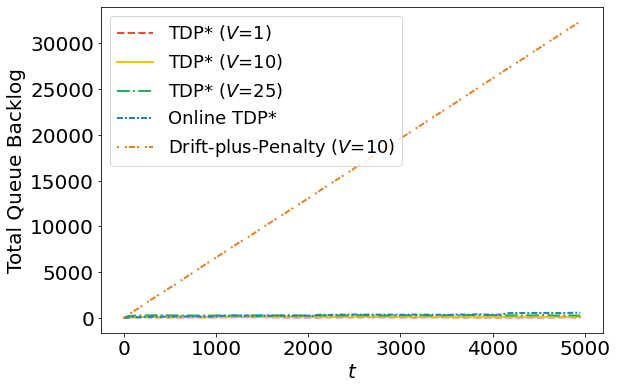

In [16]:
# plot total queue backlogs
fig = plt.figure(figsize=figSize)
ax = fig.gca()
idx = 0
for method in methods:
    total_Q_log = total_Q_logs[method]
    legend = ''
    method_para = method.split('_')
    if method_para[0] == 'TDP':
        if method_para[3] == 'T':
            legend = 'TDP*' + r' ($V$=' + method_para[1] + ')'
        else:
            legend = 'Online TDP*'
    elif method_para[0] == 'DP':
        legend = 'Drift-plus-Penalty' + r' ($V$=' + method_para[1] + ')'
    elif method == 'Rand':
        legend = 'Randomized'
    else:
        legend = 'Null'
    ax.plot(t_plot, total_Q_log[::subSample], color_set[idx], 
            linewidth=lineWidth, linestyle=linestyle_set[idx], label=legend)
    idx += 1

# labels
ax.tick_params(labelsize=labelSize)
ax.legend(prop={"size":legendSize})
plt.xlabel('$t$', fontsize=labelSize)
plt.ylabel('Total Queue Backlog', fontsize=labelSize)
plt.show()

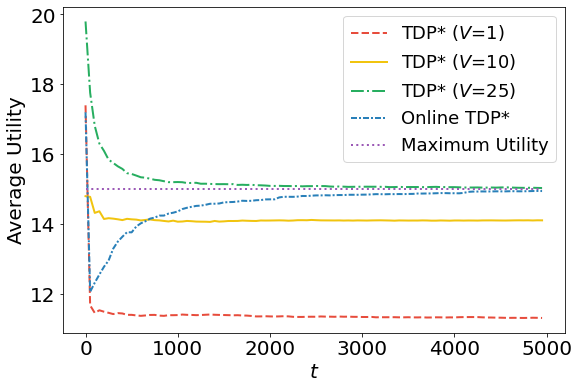

In [123]:
# plot utility
fig = plt.figure(figsize=figSize)
ax = fig.gca()
idx = 0
for method in methods:
    ave_U_log = ave_U_logs[method]
    legend = ''
    method_para = method.split('_')
    if method_para[0] == 'TDP':
        if method_para[3] == 'T':
            legend = 'TDP*' + r' ($V$=' + method_para[1] + ')'
        else:
            legend = 'Online TDP*'
    elif method_para[0] == 'DP':
        legend = 'Drift-plus-Penalty' + r' ($V$=' + method_para[1] + ')'
    elif method == 'Rand':
        legend = 'Randomized'
    else:
        legend = 'Null'
    ax.plot(t_plot, ave_U_log[::subSample], color_set[idx], 
            linewidth=lineWidth, linestyle=linestyle_set[idx], label=legend)
    idx += 1

# plot upper bound
idx += 1
ave_U_upper = [15] * sim_para['time_horizon']
ax.plot(t_plot, ave_U_upper[::subSample], color_set[idx], 
            linewidth=lineWidth, linestyle=linestyle_set[idx], label='Maximum Utility')

# labels
ax.tick_params(labelsize=labelSize)
ax.legend(prop={"size":legendSize})
plt.xlabel('$t$', fontsize=labelSize)
plt.ylabel('Average Utility', fontsize=labelSize)
plt.show()

# Ave Q - Ave U

In [24]:
# methods
coeVs = [i for i in range(1, 251, 1)]
methods = ['TDP_' + str(coeV/10) + '_0_T' for coeV in coeVs]

In [30]:
# run
sim_para['observation_slots'] = [t for t in range(0, sim_para['time_horizon'], 10)]
for method in methods:
    sim_para['method'] = method
    sim = Simulation(net_para, sim_para)
    sim.Simulate()
    pk.dump(sim.CalTotalQueue(), open(sim_para['path'] + 'Q_' + method, "wb"))
    pk.dump(sim.CalAveUtility(), open(sim_para['path'] + 'U_' + method, "wb"))

TDP_0.1_0_T, sample index = 0, t = 4999, 221.66636300086975
TDP_0.1_0_T, sample index = 1, t = 4999, 226.68756175041294
TDP_0.1_0_T, sample index = 2, t = 4999, 220.99566435813904
TDP_0.1_0_T, sample index = 3, t = 4999, 227.26995873451233
TDP_0.1_0_T, sample index = 4, t = 4999, 221.71616244316163
TDP_0.2_0_T, sample index = 0, t = 4999, 226.19014453887947
TDP_0.2_0_T, sample index = 1, t = 4999, 223.71204090118408
TDP_0.2_0_T, sample index = 2, t = 4999, 219.80179500579834
TDP_0.2_0_T, sample index = 3, t = 4999, 228.45130801200867
TDP_0.2_0_T, sample index = 4, t = 4999, 222.53434324264526
TDP_0.3_0_T, sample index = 0, t = 4999, 226.78074574470522
TDP_0.3_0_T, sample index = 1, t = 4999, 223.93976116180424
TDP_0.3_0_T, sample index = 2, t = 4999, 224.31257438659668
TDP_0.3_0_T, sample index = 3, t = 4999, 223.76277327537537
TDP_0.3_0_T, sample index = 4, t = 4999, 219.63707447052002
TDP_0.4_0_T, sample index = 0, t = 4999, 225.34891724586487
TDP_0.4_0_T, sample index = 1, t = 4999,

TDP_5.5_0_T, sample index = 2, t = 4999, 131.02952527999878
TDP_5.5_0_T, sample index = 3, t = 4999, 131.60284090042114
TDP_5.5_0_T, sample index = 4, t = 4999, 131.86683654785156
TDP_5.6_0_T, sample index = 0, t = 4999, 131.63872146606445
TDP_5.6_0_T, sample index = 1, t = 4999, 131.17142295837402
TDP_5.6_0_T, sample index = 2, t = 4999, 131.76607942581177
TDP_5.6_0_T, sample index = 3, t = 4999, 131.91861248016357
TDP_5.6_0_T, sample index = 4, t = 4999, 131.59223103523254
TDP_5.7_0_T, sample index = 0, t = 4999, 131.55870556831366
TDP_5.7_0_T, sample index = 1, t = 4999, 131.81882977485657
TDP_5.7_0_T, sample index = 2, t = 4999, 132.59690594673157
TDP_5.7_0_T, sample index = 3, t = 4999, 131.60852575302124
TDP_5.7_0_T, sample index = 4, t = 4999, 131.37486219406128
TDP_5.8_0_T, sample index = 0, t = 4999, 131.78641295433044
TDP_5.8_0_T, sample index = 1, t = 4999, 132.22397923469543
TDP_5.8_0_T, sample index = 2, t = 4999, 131.51973938941956
TDP_5.8_0_T, sample index = 3, t = 4999,

TDP_10.9_0_T, sample index = 3, t = 4999, 132.01175117492676
TDP_10.9_0_T, sample index = 4, t = 4999, 130.65925145149233
TDP_11.0_0_T, sample index = 0, t = 4999, 132.59558057785034
TDP_11.0_0_T, sample index = 1, t = 4999, 132.86437892913818
TDP_11.0_0_T, sample index = 2, t = 4999, 133.78132271766663
TDP_11.0_0_T, sample index = 3, t = 4999, 133.80076074600223
TDP_11.0_0_T, sample index = 4, t = 4999, 133.43995141983032
TDP_11.1_0_T, sample index = 0, t = 4999, 134.01252937316895
TDP_11.1_0_T, sample index = 1, t = 4999, 133.10650753974915
TDP_11.1_0_T, sample index = 2, t = 4999, 131.79445123672485
TDP_11.1_0_T, sample index = 3, t = 4999, 132.29604601860046
TDP_11.1_0_T, sample index = 4, t = 4999, 132.34299325942993
TDP_11.2_0_T, sample index = 0, t = 4999, 133.31634998321533
TDP_11.2_0_T, sample index = 1, t = 4999, 133.06605482101446
TDP_11.2_0_T, sample index = 2, t = 4999, 134.05379366874695
TDP_11.2_0_T, sample index = 3, t = 4999, 132.47256326675415
TDP_11.2_0_T, sample ind

TDP_16.3_0_T, sample index = 1, t = 4999, 125.13229799270638
TDP_16.3_0_T, sample index = 2, t = 4999, 125.50255107879639
TDP_16.3_0_T, sample index = 3, t = 4999, 125.08812379837036
TDP_16.3_0_T, sample index = 4, t = 4999, 125.94974660873413
TDP_16.4_0_T, sample index = 0, t = 4999, 126.17481970787048
TDP_16.4_0_T, sample index = 1, t = 4999, 126.27177000045776
TDP_16.4_0_T, sample index = 2, t = 4999, 124.31832122802734
TDP_16.4_0_T, sample index = 3, t = 4999, 124.89352989196777
TDP_16.4_0_T, sample index = 4, t = 4999, 124.89372992515564
TDP_16.5_0_T, sample index = 0, t = 4999, 124.97243738174438
TDP_16.5_0_T, sample index = 1, t = 4999, 124.94258904457092
TDP_16.5_0_T, sample index = 2, t = 4999, 125.02741718292236
TDP_16.5_0_T, sample index = 3, t = 4999, 124.33606839179993
TDP_16.5_0_T, sample index = 4, t = 4999, 125.72213363647461
TDP_16.6_0_T, sample index = 0, t = 4999, 124.59484243392944
TDP_16.6_0_T, sample index = 1, t = 4999, 124.90996813774109
TDP_16.6_0_T, sample ind

TDP_21.6_0_T, sample index = 4, t = 4999, 141.20028638839722
TDP_21.7_0_T, sample index = 0, t = 4999, 141.53898262977626
TDP_21.7_0_T, sample index = 1, t = 4999, 139.71073985099792
TDP_21.7_0_T, sample index = 2, t = 4999, 142.10347199440002
TDP_21.7_0_T, sample index = 3, t = 4999, 141.92506265640266
TDP_21.7_0_T, sample index = 4, t = 4999, 143.39253211021423
TDP_21.8_0_T, sample index = 0, t = 4999, 143.65300107002258
TDP_21.8_0_T, sample index = 1, t = 4999, 142.80848693847656
TDP_21.8_0_T, sample index = 2, t = 4999, 144.24377322196961
TDP_21.8_0_T, sample index = 3, t = 4999, 143.61673808097847
TDP_21.8_0_T, sample index = 4, t = 4999, 142.71468400955257
TDP_21.9_0_T, sample index = 0, t = 4999, 143.69577765464783
TDP_21.9_0_T, sample index = 1, t = 4999, 141.82732272148132
TDP_21.9_0_T, sample index = 2, t = 4999, 142.89208626747138
TDP_21.9_0_T, sample index = 3, t = 4999, 142.16556453704834
TDP_21.9_0_T, sample index = 4, t = 4999, 143.65110564231873
TDP_22.0_0_T, sample ind

In [25]:
# read data
Q_U = []
for method in methods:
    total_Q = pk.load(open(sim_para['path'] + 'Q_' + method, "rb"))
    ave_U = pk.load(open(sim_para['path'] + 'U_' + method, "rb"))
    Q_U.append((total_Q[-1], ave_U[-1]))

In [22]:
# parameters for plotting
labelSize = 20
# legendSize = 6
figSize = (9, 6)
lineWidth = 2

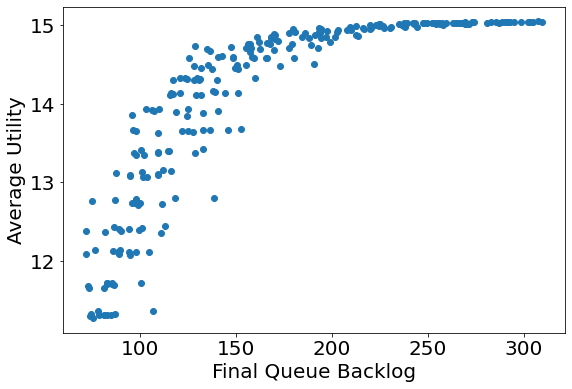

In [45]:
# scatter plot
fig = plt.figure(figsize=figSize)
ax = fig.gca()
plt.scatter([pair[0] for pair in Q_U], [pair[1] for pair in Q_U])

# q_plot = np.arange(65, 320, 1)
# u_plot = [15 - 15000/q**2 for q in q_plot]
# ax.plot(q_plot, u_plot, '#9B59B6', linewidth=lineWidth, linestyle='solid')

# labels
ax.tick_params(labelsize=labelSize)
# ax.legend(prop={"size":legendSize})
plt.xlabel('Final Queue Backlog', fontsize=labelSize)
plt.ylabel('Average Utility', fontsize=labelSize)
plt.show()